<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Task 1: Project Overview and Import Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm # for displaying the remaining time, arrow bar
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


## Task 2: Load and Preprocess the Data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# pixel values range from 0 to 255.
# lets normalize the pixel values
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
print("X train shape : ", X_train.shape)
print("y train shape : ", y_train.shape)
print("X test shape : ", X_test.shape)
print("y test shape : ", y_test.shape)

X train shape :  (60000, 28, 28)
y train shape :  (60000,)
X test shape :  (10000, 28, 28)
y test shape :  (10000,)


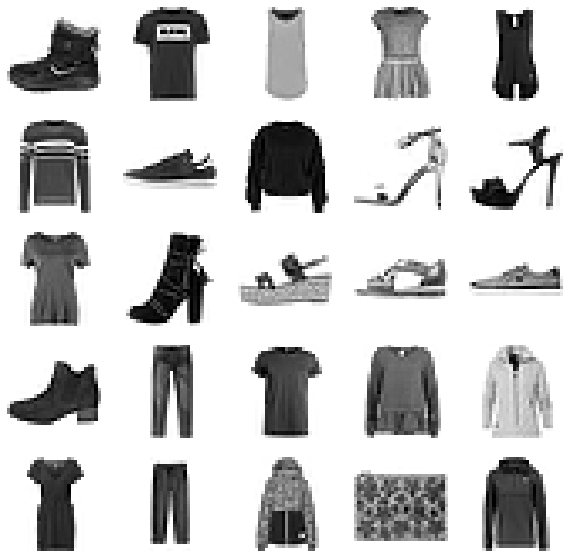

In [4]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i], cmap = 'binary')

## Task 3: Create Batches of Training Data

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
# prefetch mini-batches of data
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [6]:
print(type(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Conv2DTranspose

num_features = 100

# generator model
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape = (num_features, )))
generator.add(Reshape((7, 7, 128)))
generator.add(BatchNormalization())
# upsampling layer
generator.add(Conv2DTranspose(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', activation = 'selu'))
generator.add(BatchNormalization())
# upsampling layer
generator.add(Conv2DTranspose(filters = 1, kernel_size = (5, 5), strides = (2, 2), padding = 'same', activation = 'tanh'))

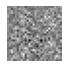

In [9]:
# gaussian noise
noise = tf.random.normal(shape = (1, num_features))
generated_image = generator(noise, training = False)
plot_utils.show(generated_image, 1)

## Task 5: Build the Discriminator Network for DCGAN

In [10]:
# the discriminator is similar to a simple CNN classification model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten

discriminator = Sequential()
discriminator.add(Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (28, 28, 1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(filters = 128, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))                  

In [13]:
# summary of generator
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [12]:
# summary of discriminator
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [14]:
# closer to 0 : fake, closer to 1 : real
decision = discriminator(generated_image, training = False)
print(decision)

tf.Tensor([[0.4986617]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [15]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
# while training the generator we dont want to train discriminator
discriminator.trainable = False

gan = Sequential([
    generator, discriminator
])
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [16]:
# gan summary
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


## Task 7: Define Training Procedure

In [17]:
seed = tf.random.normal(shape = (batch_size, num_features))

In [18]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
    generator, discriminator = gan.layers
    
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch + 1, epochs))
        
        for X_batch in dataset:
            noise = tf.random.normal(shape = (batch_size, num_features))
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            # class labels
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # class label for fake images by generated by generated as 1 to fool the discriminator.
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable= False
            
            gan.train_on_batch(noise, y2)
            
            # to produce the animated gif
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, seed)    

In [19]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [20]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2 - 1

In [23]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
# prefetch mini-batches of data
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

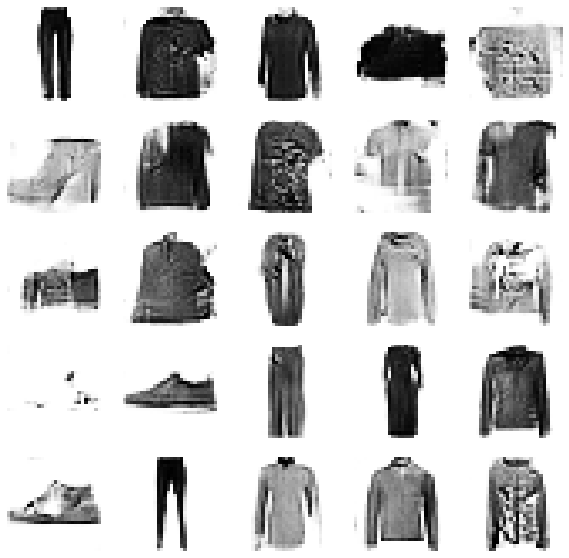

Wall time: 35min 51s


In [24]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 20)

## Task 9: Generate Synthetic Images with DCGAN

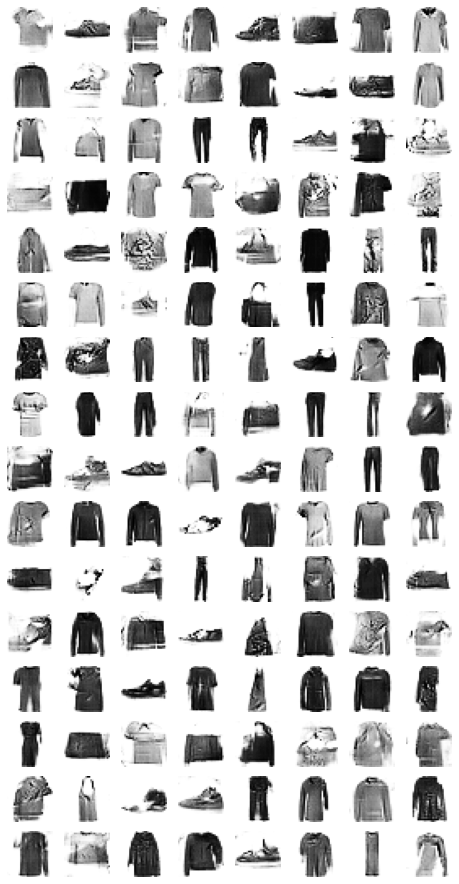

In [25]:
noise = tf.random.normal(shape = (batch_size, num_features))
# generating an image from random noise.
generated_images = generator(noise)
# no of columns = 8 : 8 x 4 grid for 32 images in a batch
plot_utils.show(generated_images, 8)

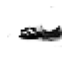

In [30]:
noise = tf.random.normal(shape = (1, num_features))
# generating an image from random noise.
generated_images = generator(noise)
# no of columns = 8 : 8 x 4 grid for 32 images in a batch
plot_utils.show(generated_images, 1)

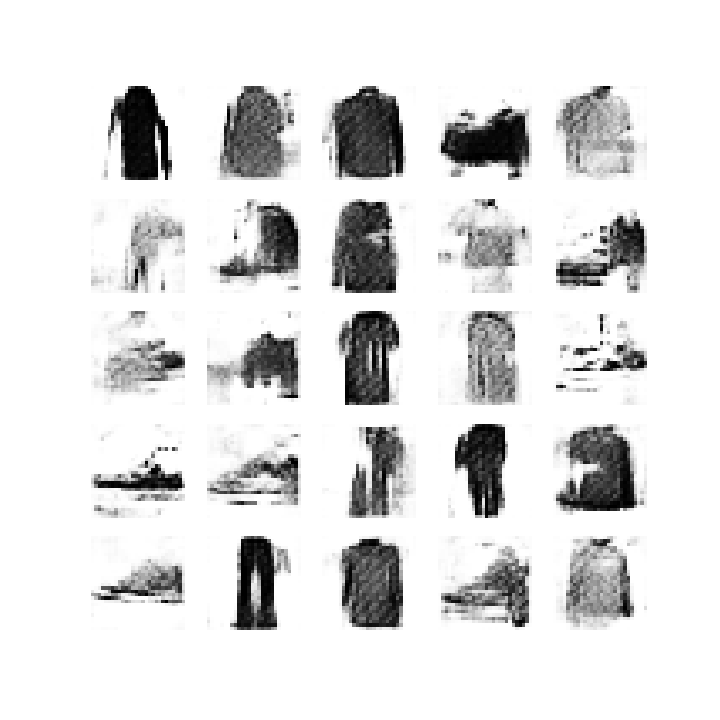

In [26]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)